# MSSE 277B: Machine Learning Algorithms 

## Homework assignment #7: Deep Learning and Regularization 

### Assigned March 9 and Due March 21 

### Student Name: Charis Liao 



In [28]:
# import modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
from time import time
from torch import nn
import torch
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split, KFold
%matplotlib inline

# 1. Biad-varaince tradeoff 
We will use the MNIST data set to train, validate, and test using a deep learning network. The input representation will be raw image vector for each number comprised of 32x32 pixels(=1024 in length) with one channel of real values between 0 (black) and 255 (white). Use cross-entropy as the loss function.     

**(a) normalize the entire data set by dividing each number image by its maximum pixel value for numerical stability.**

In [45]:
df = pd.read_pickle('mnist.pkl')

# print(f'length of df: {len(df)}')
# print(f'len df[0]: {len(df[0])}')
# print(f'len df[1]: {len(df[1])}')
# print(f'df[0][0]: {len(df[0][0])}')
# print(f'df[0][1]: {len(df[0][1])}')
# print(f'df[1][0]: {len(df[1][0])}')
# print(f'df[1][1]: {len(df[1][1])}')

In [46]:
# Normalize the entire data set
x_train = df[0][0] / 255.0
y_train = df[0][1]
x_test = df[1][0] / 255.0
y_test = df[1][1] 

**(b) The data folder you are given is already organized into a training set and a test set. Therefore, to create a validation set, divide the original training data into 3-fold groups of training (2/3 of the training data), validation (1/3 of the training data). 3-fold is because you will run 3 independent training/validation sets.**

In [47]:
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [75]:
def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform = lambda x:x.reshape(x.shape[0],-1)):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = self.input_transform(inputs)
        val_inputs = self.input_transform(val_inputs)
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 1e-5
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item() * batch_importance
                pred = torch.argmax(batch_predictions, axis=-1)
                acc = torch.sum(pred == batch_output) / len(batch_predictions)
                epoch_acc += acc.detach().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        
        inputs = self.input_transform(inputs)
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval() # change to evaluation mode so that it won't calculate gradient
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                ### Compute prediction and loss###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            pred = torch.argmax(batch_predictions, axis=-1)  
            batch_acc = torch.sum(pred == batch_output) / len(batch_predictions)
            losses += loss.detach().item() * batch_importance
            acc += batch_acc.detach().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [90]:
def kfold_MLP(splits, x_train, y_train, epochs=50, batch_size=128, learning_rate=2e-3, draw_curve=True, l2=False):
    """
    Parameters
    ----------
    splits : int
        The number of folds for cross-validation.
    model : nn.Module
        The model to be trained.
    x_train : tensor
        The training data.
    y_train : tensor
        The training labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size for training.
    learning_rate : float
        The learning rate for training.
    draw_curve : bool, optional
        Whether to draw the loss and accuracy curves. The default is True.
    """
  
    kf = KFold(n_splits=splits, shuffle=True)
    for i, (train_index, val_index) in enumerate(kf.split(x_train)):
        x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
        print(f"Fold {i+1}/{splits}")
        
        model = MLP()
        trainer = Trainer(model, "adam", learning_rate, epochs, batch_size, input_transform = lambda x:x.reshape(x.shape[0],-1))
        results = trainer.train(x_train_kf, y_train_kf, x_val_kf, y_val_kf, early_stop=True, l2=l2, silent=False)
        losses = results["losses"]
        accuracies = results["accuracies"]
        val_losses = results["val_losses"]
        val_accuracies = results["val_accuracies"]

        if draw_curve:
            plt.plot(losses, label="train")
            plt.plot(val_losses, label="val")
            plt.title(f"Training v.s. Validation Loss (Fold {i+1}/{splits})")
            plt.legend()
            plt.show()
            plt.plot(accuracies, label="train")
            plt.plot(val_accuracies, label="val")
            plt.title(f"Training v.s. Validation Accuracy (Fold {i+1}/{splits})")
            plt.legend()
            plt.show()


**(c) Devise an ANN that has 2 computing layers: a hidden layer of size 3 neurons and the final output layer of 10 output neurons and use a sigmoid activation function. Use the ADAM optimizer with learning rate of 2e-3, batchsize of 128, and 50 epochs. The prediction 𝑦𝑗𝜇 is maximum posteriori (winner take all). Converge your training to where the loss
function is minimal, and plot your training curve and validation accuracy without any further regularization, and comment on the bias-variance tradeoff with this choice.**

In [65]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 3), #(_ , some number that's power of 2) #gradient vanishing 
            nn.Sigmoid(),
            nn.Linear(3, 10),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        return self.layers(x)

Fold 1/3


  2%|▏         | 1/50 [00:00<00:36,  1.36it/s]

Epoch 1/50 - Loss: 2.238 - Acc: 0.285
              Val_loss: 2.178 - Val_acc: 0.372


 22%|██▏       | 11/50 [00:06<00:21,  1.80it/s]

Epoch 11/50 - Loss: 1.856 - Acc: 0.629
              Val_loss: 1.860 - Val_acc: 0.620


 42%|████▏     | 21/50 [00:11<00:15,  1.86it/s]

Epoch 21/50 - Loss: 1.826 - Acc: 0.641
              Val_loss: 1.837 - Val_acc: 0.628


 62%|██████▏   | 31/50 [00:16<00:10,  1.83it/s]

Epoch 31/50 - Loss: 1.799 - Acc: 0.681
              Val_loss: 1.799 - Val_acc: 0.683


 82%|████████▏ | 41/50 [00:22<00:05,  1.74it/s]

Epoch 41/50 - Loss: 1.746 - Acc: 0.719
              Val_loss: 1.761 - Val_acc: 0.702


func:'train'  took: 27.0373 sec


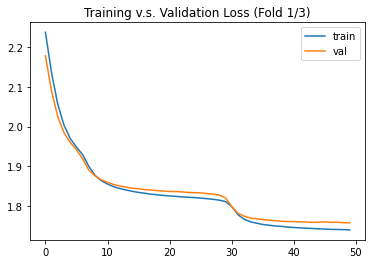

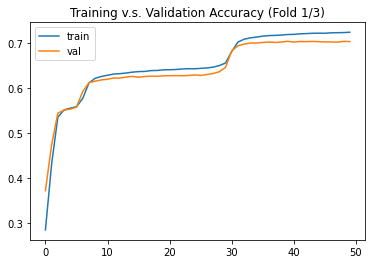

Fold 2/3


  2%|▏         | 1/50 [00:00<00:27,  1.77it/s]

Epoch 1/50 - Loss: 2.251 - Acc: 0.263
              Val_loss: 2.202 - Val_acc: 0.356


 22%|██▏       | 11/50 [00:06<00:22,  1.73it/s]

Epoch 11/50 - Loss: 1.862 - Acc: 0.634
              Val_loss: 1.862 - Val_acc: 0.626


 42%|████▏     | 21/50 [00:12<00:16,  1.81it/s]

Epoch 21/50 - Loss: 1.801 - Acc: 0.687
              Val_loss: 1.811 - Val_acc: 0.675


 62%|██████▏   | 31/50 [00:16<00:09,  2.03it/s]

Epoch 31/50 - Loss: 1.771 - Acc: 0.712
              Val_loss: 1.783 - Val_acc: 0.698


 82%|████████▏ | 41/50 [00:21<00:04,  1.91it/s]

Epoch 41/50 - Loss: 1.731 - Acc: 0.751
              Val_loss: 1.742 - Val_acc: 0.737


func:'train'  took: 26.1453 sec


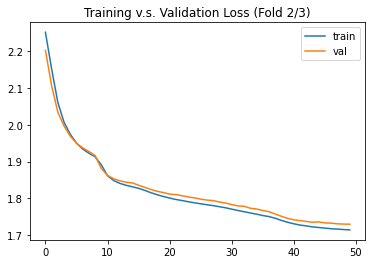

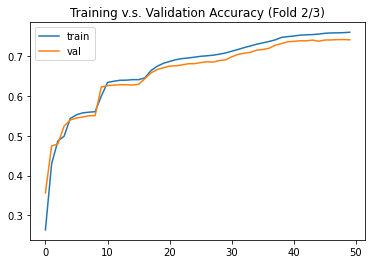

Fold 3/3


  2%|▏         | 1/50 [00:00<00:31,  1.57it/s]

Epoch 1/50 - Loss: 2.239 - Acc: 0.338
              Val_loss: 2.165 - Val_acc: 0.454


 22%|██▏       | 11/50 [00:05<00:16,  2.37it/s]

Epoch 11/50 - Loss: 1.842 - Acc: 0.648
              Val_loss: 1.842 - Val_acc: 0.645


 42%|████▏     | 21/50 [00:09<00:16,  1.80it/s]

Epoch 21/50 - Loss: 1.806 - Acc: 0.662
              Val_loss: 1.812 - Val_acc: 0.654


 62%|██████▏   | 31/50 [00:15<00:11,  1.67it/s]

Epoch 31/50 - Loss: 1.771 - Acc: 0.707
              Val_loss: 1.776 - Val_acc: 0.702


 82%|████████▏ | 41/50 [00:21<00:04,  1.82it/s]

Epoch 41/50 - Loss: 1.757 - Acc: 0.717
              Val_loss: 1.765 - Val_acc: 0.706


func:'train'  took: 25.4196 sec


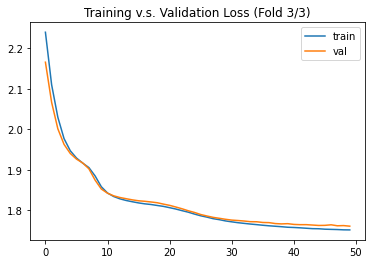

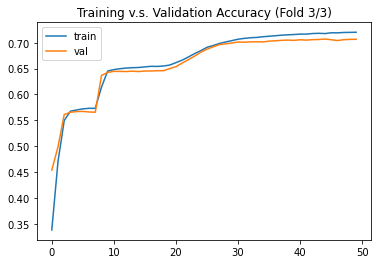

In [91]:
kfold_MLP(3, x_train, y_train)

During the three-fold cross-validation process, the training and validation losses decreased over time, while the training and validation accuracies increased. However, in the third fold, the validation accuracy did not increase as significantly as the training accuracy, indicating a potential overfitting issue. This trend is related to the bias-variance tradeoff, where the model needs to balance the complexity (variance) and simplicity (bias) to achieve good generalization performance.

**(d) Devise another ANN with hidden layer of size 50. Do the same as in (1c). Plot your training and validation curve, and comment on the bias-variance tradeoff with this choice.**

In [93]:
class MLP_50(nn.Module):
    def __init__(self):
        super(MLP_50, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 50), #(_ , some number that's power of 2) #gradient vanishing 
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [94]:
def kfold_MLP_50(splits, x_train, y_train, epochs=50, batch_size=128, learning_rate=2e-3, draw_curve=True, l2=False):
    """
    Parameters
    ----------
    splits : int
        The number of folds for cross-validation.
    model : nn.Module
        The model to be trained.
    x_train : tensor
        The training data.
    y_train : tensor
        The training labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size for training.
    learning_rate : float
        The learning rate for training.
    draw_curve : bool, optional
        Whether to draw the loss and accuracy curves. The default is True.
    """
  
    kf = KFold(n_splits=splits, shuffle=True)
    for i, (train_index, val_index) in enumerate(kf.split(x_train)):
        x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
        print(f"Fold {i+1}/{splits}")
        
        model = MLP_50()
        trainer = Trainer(model, "adam", learning_rate, epochs, batch_size, input_transform = lambda x:x.reshape(x.shape[0],-1))
        results = trainer.train(x_train_kf, y_train_kf, x_val_kf, y_val_kf, early_stop=True, l2=l2, silent=False)
        losses = results["losses"]
        accuracies = results["accuracies"]
        val_losses = results["val_losses"]
        val_accuracies = results["val_accuracies"]

        if draw_curve:
            plt.plot(losses, label="train")
            plt.plot(val_losses, label="val")
            plt.title(f"Training v.s. Validation Loss (Fold {i+1}/{splits})")
            plt.legend()
            plt.show()
            plt.plot(accuracies, label="train")
            plt.plot(val_accuracies, label="val")
            plt.title(f"Training v.s. Validation Accuracy (Fold {i+1}/{splits})")
            plt.legend()
            plt.show()


Fold 1/3


  2%|▏         | 1/50 [00:01<00:57,  1.18s/it]

Epoch 1/50 - Loss: 1.865 - Acc: 0.660
              Val_loss: 1.635 - Val_acc: 0.890


 22%|██▏       | 11/50 [00:12<00:42,  1.10s/it]

Epoch 11/50 - Loss: 1.503 - Acc: 0.967
              Val_loss: 1.516 - Val_acc: 0.952


 42%|████▏     | 21/50 [00:25<00:36,  1.27s/it]

Epoch 21/50 - Loss: 1.486 - Acc: 0.980
              Val_loss: 1.507 - Val_acc: 0.957


 62%|██████▏   | 31/50 [00:37<00:23,  1.23s/it]

Epoch 31/50 - Loss: 1.478 - Acc: 0.986
              Val_loss: 1.504 - Val_acc: 0.960


 82%|████████▏ | 41/50 [00:50<00:11,  1.26s/it]

Epoch 41/50 - Loss: 1.474 - Acc: 0.988
              Val_loss: 1.502 - Val_acc: 0.961


func:'train'  took: 61.1527 sec


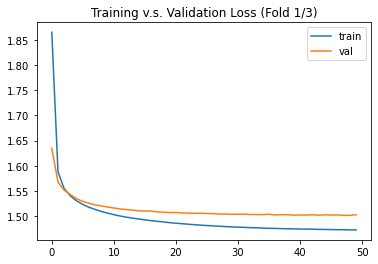

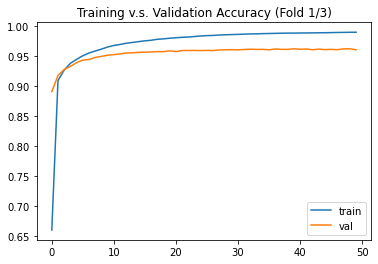

Fold 2/3


  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

Epoch 1/50 - Loss: 1.855 - Acc: 0.692
              Val_loss: 1.687 - Val_acc: 0.820


 22%|██▏       | 11/50 [00:15<00:46,  1.20s/it]

Epoch 11/50 - Loss: 1.504 - Acc: 0.966
              Val_loss: 1.518 - Val_acc: 0.949


 42%|████▏     | 21/50 [00:26<00:33,  1.15s/it]

Epoch 21/50 - Loss: 1.487 - Acc: 0.980
              Val_loss: 1.509 - Val_acc: 0.955


 62%|██████▏   | 31/50 [00:37<00:19,  1.04s/it]

Epoch 31/50 - Loss: 1.479 - Acc: 0.985
              Val_loss: 1.506 - Val_acc: 0.957


 82%|████████▏ | 41/50 [00:48<00:10,  1.12s/it]

Epoch 41/50 - Loss: 1.475 - Acc: 0.987
              Val_loss: 1.505 - Val_acc: 0.958


func:'train'  took: 59.0876 sec


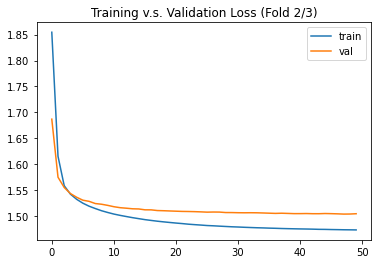

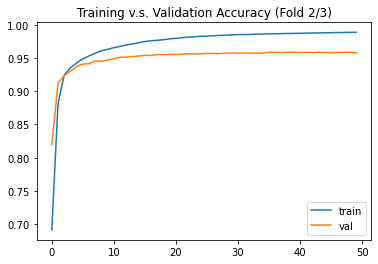

Fold 3/3


  2%|▏         | 1/50 [00:01<01:18,  1.61s/it]

Epoch 1/50 - Loss: 1.837 - Acc: 0.694
              Val_loss: 1.650 - Val_acc: 0.842


 22%|██▏       | 11/50 [00:15<00:49,  1.27s/it]

Epoch 11/50 - Loss: 1.504 - Acc: 0.966
              Val_loss: 1.516 - Val_acc: 0.951


 42%|████▏     | 21/50 [00:25<00:30,  1.06s/it]

Epoch 21/50 - Loss: 1.486 - Acc: 0.980
              Val_loss: 1.507 - Val_acc: 0.959


 62%|██████▏   | 31/50 [00:37<00:24,  1.27s/it]

Epoch 31/50 - Loss: 1.478 - Acc: 0.986
              Val_loss: 1.503 - Val_acc: 0.961


 82%|████████▏ | 41/50 [00:50<00:11,  1.30s/it]

Epoch 41/50 - Loss: 1.474 - Acc: 0.989
              Val_loss: 1.503 - Val_acc: 0.960


func:'train'  took: 62.6237 sec


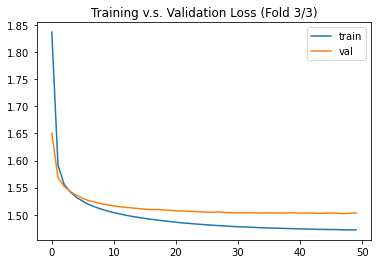

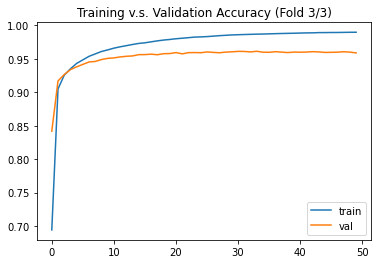

In [95]:
kfold_MLP_50(3, x_train, y_train)

A similar trend was observed where the training loss and accuracy decreased over time; however, 1d performs better than 1c with higher accuracy. This might due to the fact that the larger hidden layer size may allow for more complex representations of the data, potentially reducing the bias in the model.

# 2. Deep Learning and regularization

**(a) Using the ANN from 1(d), utilize dropout with 15%. Compare your training and test accuracy to results
in (d).**

In [76]:
class MLP_15(nn.Module):
    def __init__(self):
        super(MLP_15, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 50), #(_ , some number that's power of 2) #gradient vanishing 
            nn.Dropout(p=0.15),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Dropout(p=0.15),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [96]:
def kfold_MLP_15(splits, x_train, y_train, epochs=50, batch_size=128, learning_rate=2e-3, draw_curve=True, l2=False):
    """
    Parameters
    ----------
    splits : int
        The number of folds for cross-validation.
    model : nn.Module
        The model to be trained.
    x_train : tensor
        The training data.
    y_train : tensor
        The training labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size for training.
    learning_rate : float
        The learning rate for training.
    draw_curve : bool, optional
        Whether to draw the loss and accuracy curves. The default is True.
    """
  
    kf = KFold(n_splits=splits, shuffle=True)
    for i, (train_index, val_index) in enumerate(kf.split(x_train)):
        x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
        print(f"Fold {i+1}/{splits}")
        
        model = MLP_15()
        trainer = Trainer(model, "adam", learning_rate, epochs, batch_size, input_transform = lambda x:x.reshape(x.shape[0],-1))
        results = trainer.train(x_train_kf, y_train_kf, x_val_kf, y_val_kf, early_stop=True, l2=l2, silent=False)
        losses = results["losses"]
        accuracies = results["accuracies"]
        val_losses = results["val_losses"]
        val_accuracies = results["val_accuracies"]

        if draw_curve:
            plt.plot(losses, label="train")
            plt.plot(val_losses, label="val")
            plt.title(f"Training v.s. Validation Loss (Fold {i+1}/{splits})")
            plt.legend()
            plt.show()
            plt.plot(accuracies, label="train")
            plt.plot(val_accuracies, label="val")
            plt.title(f"Training v.s. Validation Accuracy (Fold {i+1}/{splits})")
            plt.legend()
            plt.show()


Fold 1/3


  2%|▏         | 1/50 [00:01<01:17,  1.59s/it]

Epoch 1/50 - Loss: 1.901 - Acc: 0.625
              Val_loss: 1.667 - Val_acc: 0.830


 22%|██▏       | 11/50 [00:15<00:52,  1.35s/it]

Epoch 11/50 - Loss: 1.593 - Acc: 0.876
              Val_loss: 1.525 - Val_acc: 0.940


 42%|████▏     | 21/50 [00:28<00:35,  1.21s/it]

Epoch 21/50 - Loss: 1.576 - Acc: 0.888
              Val_loss: 1.516 - Val_acc: 0.947


 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

Epoch 31/50 - Loss: 1.572 - Acc: 0.891
              Val_loss: 1.513 - Val_acc: 0.948


 82%|████████▏ | 41/50 [00:54<00:10,  1.17s/it]

Epoch 41/50 - Loss: 1.567 - Acc: 0.894
              Val_loss: 1.510 - Val_acc: 0.951


func:'train'  took: 64.5700 sec


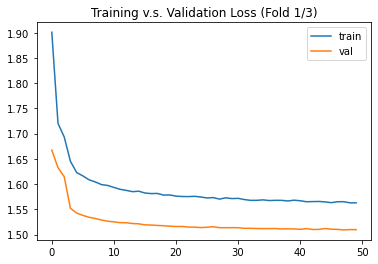

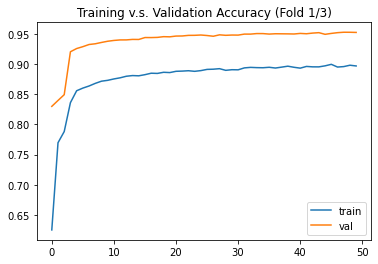

Fold 2/3


  2%|▏         | 1/50 [00:01<01:12,  1.48s/it]

Epoch 1/50 - Loss: 1.911 - Acc: 0.625
              Val_loss: 1.640 - Val_acc: 0.887


 22%|██▏       | 11/50 [00:14<00:47,  1.21s/it]

Epoch 11/50 - Loss: 1.592 - Acc: 0.877
              Val_loss: 1.528 - Val_acc: 0.937


 42%|████▏     | 21/50 [00:28<00:37,  1.29s/it]

Epoch 21/50 - Loss: 1.575 - Acc: 0.889
              Val_loss: 1.518 - Val_acc: 0.945


 62%|██████▏   | 31/50 [00:40<00:22,  1.17s/it]

Epoch 31/50 - Loss: 1.568 - Acc: 0.895
              Val_loss: 1.515 - Val_acc: 0.947


 82%|████████▏ | 41/50 [00:51<00:10,  1.15s/it]

Epoch 41/50 - Loss: 1.565 - Acc: 0.896
              Val_loss: 1.513 - Val_acc: 0.949


func:'train'  took: 62.7182 sec


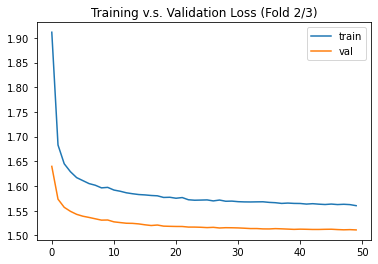

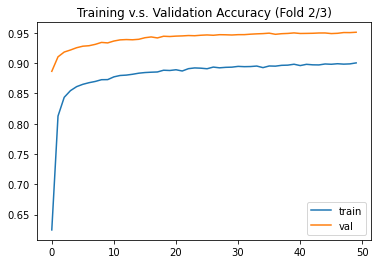

Fold 3/3


  2%|▏         | 1/50 [00:01<01:22,  1.68s/it]

Epoch 1/50 - Loss: 1.922 - Acc: 0.601
              Val_loss: 1.643 - Val_acc: 0.886


 22%|██▏       | 11/50 [00:16<00:59,  1.53s/it]

Epoch 11/50 - Loss: 1.595 - Acc: 0.874
              Val_loss: 1.522 - Val_acc: 0.943


 42%|████▏     | 21/50 [00:29<00:39,  1.36s/it]

Epoch 21/50 - Loss: 1.578 - Acc: 0.887
              Val_loss: 1.515 - Val_acc: 0.948


 62%|██████▏   | 31/50 [00:43<00:26,  1.40s/it]

Epoch 31/50 - Loss: 1.571 - Acc: 0.890
              Val_loss: 1.512 - Val_acc: 0.951


 82%|████████▏ | 41/50 [00:57<00:13,  1.46s/it]

Epoch 41/50 - Loss: 1.563 - Acc: 0.899
              Val_loss: 1.509 - Val_acc: 0.952


func:'train'  took: 68.5365 sec


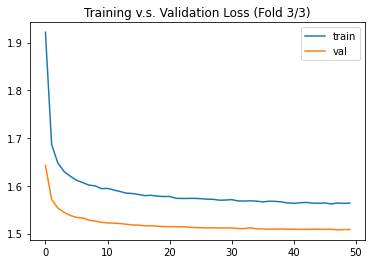

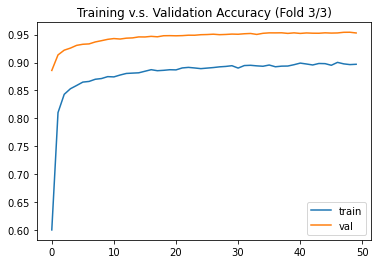

In [97]:
kfold_MLP_15(3, x_train, y_train)

From the graphs produced above, we observed that the training accuracy is lower than the validation accuracy where as in 1d it's the opposit. This is because in our ANN model has dropout layers to regularize and prevent overfitting for the network. 

**(b) Using the ANN from 1(d), utilize L2 regularization with lambda=1e-5. How does the result compare to (d)?**

Fold 1/3


  2%|▏         | 1/50 [00:01<01:10,  1.44s/it]

Epoch 1/50 - Loss: 1.870 - Acc: 0.664
              Val_loss: 1.684 - Val_acc: 0.821


 22%|██▏       | 11/50 [00:13<00:48,  1.24s/it]

Epoch 11/50 - Loss: 1.523 - Acc: 0.964
              Val_loss: 1.519 - Val_acc: 0.952


 42%|████▏     | 21/50 [00:25<00:35,  1.23s/it]

Epoch 21/50 - Loss: 1.510 - Acc: 0.976
              Val_loss: 1.509 - Val_acc: 0.960


 62%|██████▏   | 31/50 [00:38<00:21,  1.14s/it]

Epoch 31/50 - Loss: 1.505 - Acc: 0.982
              Val_loss: 1.504 - Val_acc: 0.964


 82%|████████▏ | 41/50 [00:48<00:09,  1.03s/it]

Epoch 41/50 - Loss: 1.502 - Acc: 0.986
              Val_loss: 1.502 - Val_acc: 0.966


func:'train'  took: 58.6354 sec


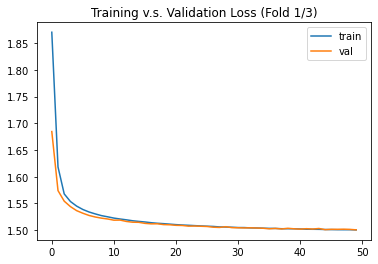

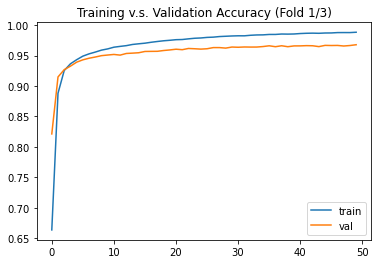

Fold 2/3


  2%|▏         | 1/50 [00:01<01:00,  1.24s/it]

Epoch 1/50 - Loss: 1.848 - Acc: 0.696
              Val_loss: 1.611 - Val_acc: 0.900


 22%|██▏       | 11/50 [00:13<00:46,  1.19s/it]

Epoch 11/50 - Loss: 1.524 - Acc: 0.962
              Val_loss: 1.520 - Val_acc: 0.951


 42%|████▏     | 21/50 [00:24<00:31,  1.10s/it]

Epoch 21/50 - Loss: 1.511 - Acc: 0.977
              Val_loss: 1.511 - Val_acc: 0.958


 62%|██████▏   | 31/50 [00:37<00:23,  1.23s/it]

Epoch 31/50 - Loss: 1.505 - Acc: 0.983
              Val_loss: 1.506 - Val_acc: 0.962


 82%|████████▏ | 41/50 [00:48<00:10,  1.16s/it]

Epoch 41/50 - Loss: 1.503 - Acc: 0.986
              Val_loss: 1.503 - Val_acc: 0.964


func:'train'  took: 59.3970 sec


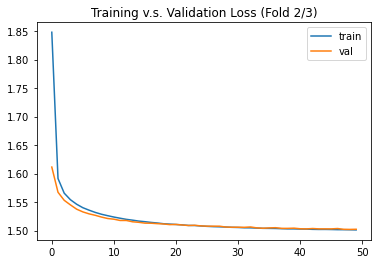

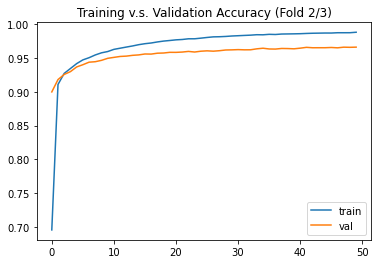

Fold 3/3


  2%|▏         | 1/50 [00:01<00:52,  1.07s/it]

Epoch 1/50 - Loss: 1.844 - Acc: 0.707
              Val_loss: 1.664 - Val_acc: 0.831


 22%|██▏       | 11/50 [00:14<00:47,  1.22s/it]

Epoch 11/50 - Loss: 1.523 - Acc: 0.963
              Val_loss: 1.520 - Val_acc: 0.950


 42%|████▏     | 21/50 [00:26<00:38,  1.32s/it]

Epoch 21/50 - Loss: 1.510 - Acc: 0.977
              Val_loss: 1.509 - Val_acc: 0.960


 62%|██████▏   | 31/50 [00:38<00:21,  1.12s/it]

Epoch 31/50 - Loss: 1.505 - Acc: 0.983
              Val_loss: 1.505 - Val_acc: 0.963


 82%|████████▏ | 41/50 [00:49<00:10,  1.14s/it]

Epoch 41/50 - Loss: 1.502 - Acc: 0.986
              Val_loss: 1.503 - Val_acc: 0.965


func:'train'  took: 60.0533 sec


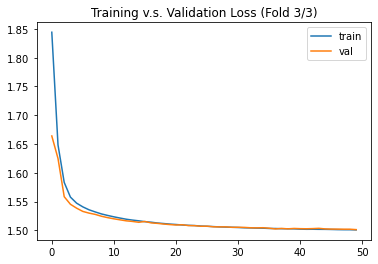

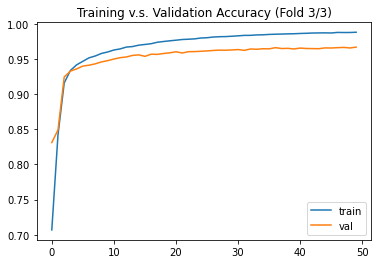

In [98]:
kfold_MLP_50(3, x_train, y_train, l2=True)

This ANN model with l2 regularization performs better than 1d as the validation accuracy in 2b is higher than 1d.

**(c) Use principal component analysis on the input, to create a reduced set of input features, keeping 99% of the variance. This is a type of data transformation! How many parameters do you have in this case and how does it compare to the original model (i.e. the ANN in 1(d))?**

In [85]:
print(f'Parameters of Original model = {sum([len(item.flatten()) for item in mlp_50.parameters()])}')

Parameters of Original model = 51760


In [103]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99) # how many features do you want to keep
x_train_reshape = x_train.reshape(x_train.shape[0], -1)
x_pca = pca.fit_transform(x_train_reshape)
x_pca.shape

(60000, 331)

In [87]:
class MLP_pca(nn.Module):
    def __init__(self):
        super(MLP_pca, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(331, 50), #(_ , some number that's power of 2) #gradient vanishing 
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        return self.layers(x)
    
mlp_pca = MLP_pca()
print(f'Parameters of the PCA model = {sum([len(item.flatten()) for item in mlp_pca.parameters()])}')

Parameters of the PCA model = 17110


**(d) Use the regularization settings (2a or 2b) that give the best result so far, and using the reduced input space from (c) run the model again. Is the training faster and better this time?**

In [99]:
def kfold_MLP_pca(splits, x_train, y_train, epochs=50, batch_size=128, learning_rate=2e-3, draw_curve=True, l2=False):
    """
    Parameters
    ----------
    splits : int
        The number of folds for cross-validation.
    model : nn.Module
        The model to be trained.
    x_train : tensor
        The training data.
    y_train : tensor
        The training labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size for training.
    learning_rate : float
        The learning rate for training.
    draw_curve : bool, optional
        Whether to draw the loss and accuracy curves. The default is True.
    """
  
    kf = KFold(n_splits=splits, shuffle=True)
    for i, (train_index, val_index) in enumerate(kf.split(x_train)):
        x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
        print(f"Fold {i+1}/{splits}")
        
        model = MLP_pca()
        trainer = Trainer(model, "adam", learning_rate, epochs, batch_size, input_transform = lambda x:x.reshape(x.shape[0],-1))
        results = trainer.train(x_train_kf, y_train_kf, x_val_kf, y_val_kf, early_stop=True, l2=l2, silent=False)
        losses = results["losses"]
        accuracies = results["accuracies"]
        val_losses = results["val_losses"]
        val_accuracies = results["val_accuracies"]

        if draw_curve:
            plt.plot(losses, label="train")
            plt.plot(val_losses, label="val")
            plt.title(f"Training v.s. Validation Loss (Fold {i+1}/{splits})")
            plt.legend()
            plt.show()
            plt.plot(accuracies, label="train")
            plt.plot(val_accuracies, label="val")
            plt.title(f"Training v.s. Validation Accuracy (Fold {i+1}/{splits})")
            plt.legend()
            plt.show()


Fold 1/3


  2%|▏         | 1/50 [00:00<00:40,  1.21it/s]

Epoch 1/50 - Loss: 1.967 - Acc: 0.559
              Val_loss: 1.716 - Val_acc: 0.813


 22%|██▏       | 11/50 [00:08<00:28,  1.36it/s]

Epoch 11/50 - Loss: 1.529 - Acc: 0.956
              Val_loss: 1.530 - Val_acc: 0.939


 42%|████▏     | 21/50 [00:15<00:22,  1.27it/s]

Epoch 21/50 - Loss: 1.516 - Acc: 0.970
              Val_loss: 1.519 - Val_acc: 0.949


 62%|██████▏   | 31/50 [00:22<00:13,  1.39it/s]

Epoch 31/50 - Loss: 1.510 - Acc: 0.978
              Val_loss: 1.514 - Val_acc: 0.953


 82%|████████▏ | 41/50 [00:28<00:04,  1.82it/s]

Epoch 41/50 - Loss: 1.507 - Acc: 0.982
              Val_loss: 1.511 - Val_acc: 0.957


func:'train'  took: 33.5825 sec


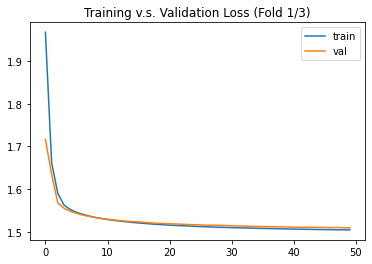

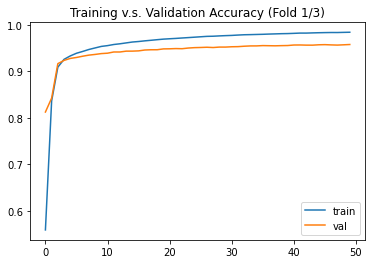

Fold 2/3


  2%|▏         | 1/50 [00:00<00:24,  1.99it/s]

Epoch 1/50 - Loss: 1.963 - Acc: 0.563
              Val_loss: 1.738 - Val_acc: 0.753


 22%|██▏       | 11/50 [00:05<00:19,  2.00it/s]

Epoch 11/50 - Loss: 1.530 - Acc: 0.955
              Val_loss: 1.529 - Val_acc: 0.941


 42%|████▏     | 21/50 [00:10<00:14,  1.98it/s]

Epoch 21/50 - Loss: 1.516 - Acc: 0.971
              Val_loss: 1.518 - Val_acc: 0.949


 62%|██████▏   | 31/50 [00:15<00:09,  1.91it/s]

Epoch 31/50 - Loss: 1.511 - Acc: 0.977
              Val_loss: 1.513 - Val_acc: 0.954


 82%|████████▏ | 41/50 [00:20<00:04,  2.01it/s]

Epoch 41/50 - Loss: 1.507 - Acc: 0.982
              Val_loss: 1.509 - Val_acc: 0.958


func:'train'  took: 25.4740 sec


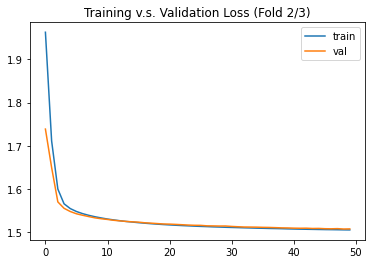

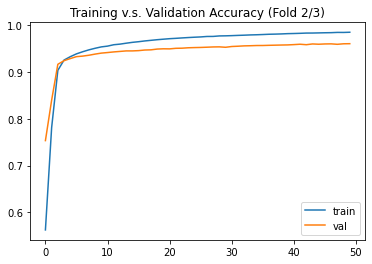

Fold 3/3


  2%|▏         | 1/50 [00:00<00:24,  2.02it/s]

Epoch 1/50 - Loss: 1.952 - Acc: 0.583
              Val_loss: 1.685 - Val_acc: 0.852


 22%|██▏       | 11/50 [00:06<00:22,  1.73it/s]

Epoch 11/50 - Loss: 1.531 - Acc: 0.954
              Val_loss: 1.533 - Val_acc: 0.936


 42%|████▏     | 21/50 [00:11<00:15,  1.87it/s]

Epoch 21/50 - Loss: 1.517 - Acc: 0.970
              Val_loss: 1.521 - Val_acc: 0.947


 62%|██████▏   | 31/50 [00:17<00:11,  1.70it/s]

Epoch 31/50 - Loss: 1.511 - Acc: 0.977
              Val_loss: 1.516 - Val_acc: 0.951


 82%|████████▏ | 41/50 [00:22<00:04,  1.82it/s]

Epoch 41/50 - Loss: 1.507 - Acc: 0.981
              Val_loss: 1.513 - Val_acc: 0.953


func:'train'  took: 27.1530 sec


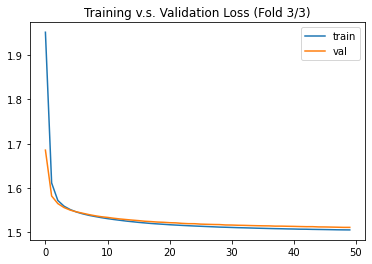

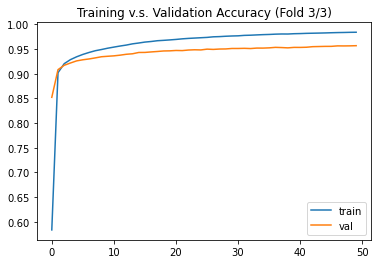

In [105]:
kfold_MLP_pca(3, x_pca, y_train, l2=True)

Training is faster this time; however, the validation accuracy does not do as well because after we reduce some dimension, the information gets lost. 

# You've reached the end of hw7 

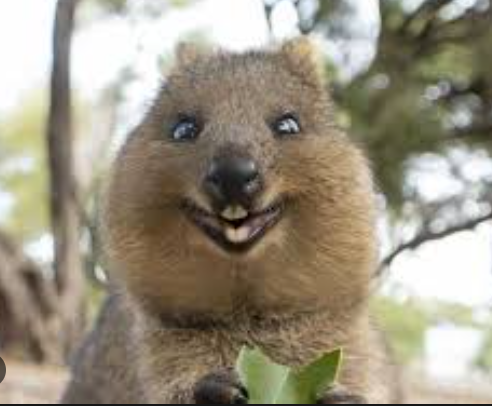